<a href="https://colab.research.google.com/github/AlexandreBourrieau/ML/blob/main/Carnets%20Jupyter/Series_caracteristiques.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Découvrons quelques séries temporelles afin de mieux comprendre les caractéristiques de ce type de données.

# Importation des bibliothèques

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

Fonction permettant d'afficher une série temporelle



In [2]:
def affiche_serie(temps, serie, format="-", debut=0, fin=None, label=None):
    plt.plot(temps[debut:fin], serie[debut:fin], format, label=label)
    plt.xlabel("Temps")
    plt.ylabel("Valeur")
    if label:
        plt.legend(fontsize=14)
    plt.grid(True)

# Tendance et saisonnalité

Définition d'une fonction pour créer un courbe de tendance avec une pente que l'on peut choisir

In [3]:
def tendance(temps, pente=0):
    return pente * temps

Création d'une série temporelle avec la fonction précédente :

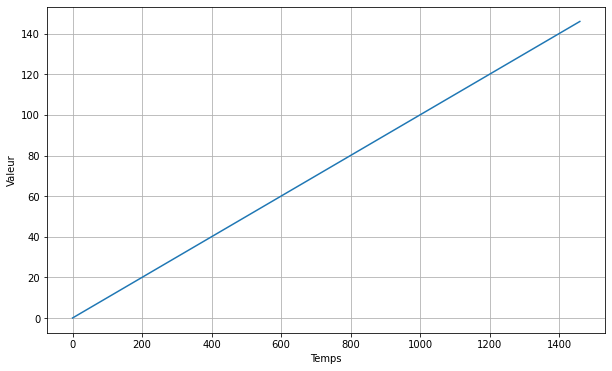

In [4]:
temps = np.arange(4 * 365 + 1)            # temps = [0 1 2 .... 4*365] = [0 1 2 .... 1460]
serie = tendance(temps, 0.1)              # serie = droite de pente 0.1

plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.show()

Ajoutons maintenant un motif périodique à notre série. Tout d'abord, définissons le motif que nous allons répéter :

$motif = \left\{ {\begin{array}{*{20}{c}}
{\cos \left( {2\pi t} \right){\rm{       }}\qquad0 \le t < 0.4}\\
{{e^{ - 3t}}{\rm{                }}\qquad\qquad0.4 \le t \le 1}
\end{array}} \right.$

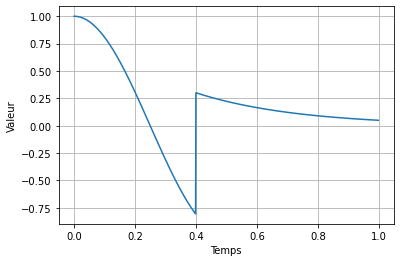

In [5]:
# Définition du motif périodique sur t:[0:1]
t = np.arange(1000)
t = t/1000
motif = np.where(t < 0.4,np.cos(t * 2 * np.pi),1 / np.exp(3 * t))

# Affichage du motif sur t:[0,1]
plt.plot(t[0:1000], motif[0:1000], "-", label="Motif")
plt.xlabel("Temps")
plt.ylabel("Valeur")
plt.grid(True)


Définissons maintenant les fonctions pour ajouter le motif à notre courbe de tendance :  
- `motif_periodique`: Cette fonction créée le motif sur des instants t = [0,1]
- `ajoute_motif` : Cette fonction ajoute le motif à la série 

In [6]:
def motif_periodique(instants):
    return (np.where(instants < 0.4,                            # Si les instants sont < 0.4
                    np.cos(instants * 2 * np.pi),               # Alors on retourne la fonction cos(2*pi*t)
                    1 / np.exp(3 * instants)))                  # Sinon, on retourne la fonction exp(-3t)

def saisonnalite(temps, periode, amplitude=1, phase=0):
    """Répétition du motif sur la même période"""
    instants = ((temps + phase) % periode) / periode            # Mapping du temps =[0 1 2 ... 1460] => instants = [0.0 ... 1.0]
    return amplitude * motif_periodique(instants)

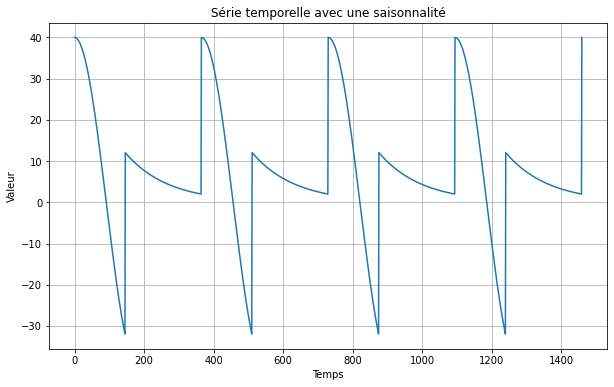

In [8]:
# Création de la série avec une saisonnalité
amplitude = 40
serie = saisonnalite(temps, periode=365, amplitude=amplitude)

#Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec une saisonnalité")
plt.show()


Ajoutons maintenant une tendance à cette série :

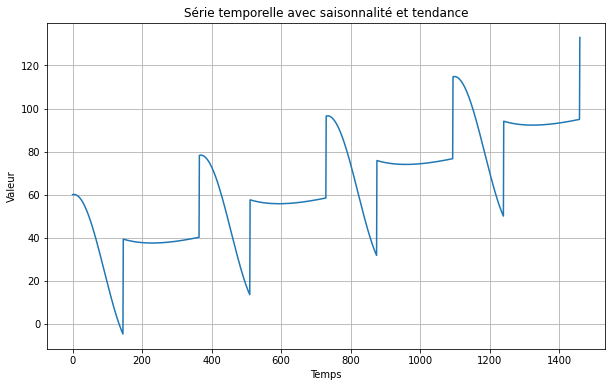

In [9]:
# Création d'une tendance et ajout de la tendance à la série
offset = 20
pente = 0.05
serie = offset + tendance(temps, pente) + saisonnalite(temps, periode=365, amplitude=amplitude)

# Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec saisonnalité et tendance")
plt.show()

# Bruit

En pratique, très peu de séries temporelles sont aussi jolies ! Elles ont souvent du bruit, et le ratio signal / bruit peut parfois être très faible.  
Générons du [bruit blanc](https://fr.wikipedia.org/wiki/Bruit_blanc) :

In [11]:
# Fonction permettant de générer du bruit gaussien N(0,1)
def bruit_blanc(temps, niveau_bruit=1, graine=None):
    rnd = np.random.RandomState(graine)
    return rnd.randn(len(temps)) * niveau_bruit

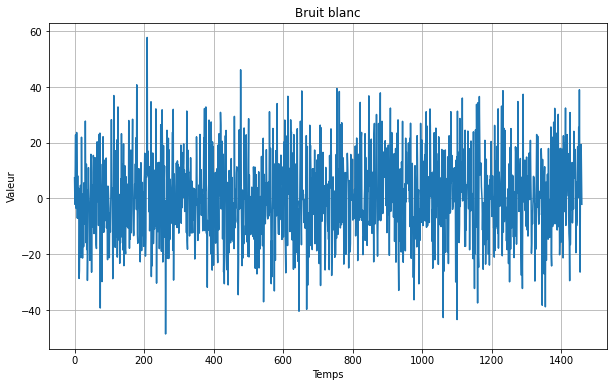

In [12]:
# Création du bruit
niveau_bruit = 15
bruit = bruit_blanc(temps, niveau_bruit, graine=42)

# Affichage du résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, bruit)
plt.title("Bruit blanc")
plt.show()

Ajoutons maintenant ce bruit à notre série temporelle :

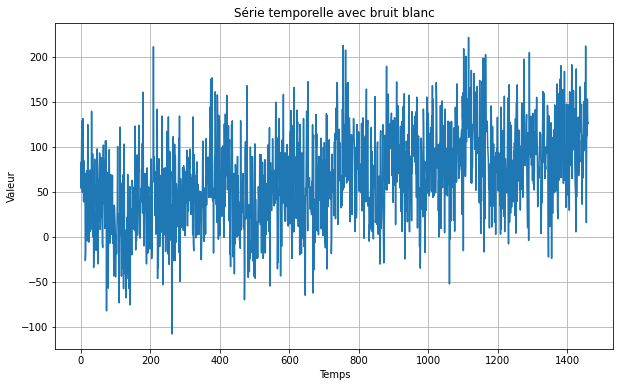

In [15]:
# Ajoute le bruit gaussien à la série temporelle
serie = serie + bruit

# Affiche le résultat
plt.figure(figsize=(10, 6))
affiche_serie(temps, serie)
plt.title("Série temporelle avec bruit blanc")
plt.show()

# Fonctions autocorrélées

Définissons maintenant deux fonctions autocorrélées :  

$\left\{ \begin{array}{l}
{v_1}(t) = 0.8v_1(t - 1) + bruit\\
{v_2}(t) = 0.5v_2(t - 50) - 0.1v_2(t - 33) + bruit
\end{array} \right.$

In [16]:
# Fonction autocorréllée #1
# v(t) = 0.8v(t-1) + bruit

def autocorrelation1(temps, amplitude, graine=None):
    rnd = np.random.RandomState(graine)                 # Génération du bruit blanc
    φ = 0.8
    ar = rnd.randn(len(temps) + 1)
    for step in range(1, len(temps) + 1):
        ar[step] = ar[step] + φ * ar[step - 1]
    return ar[1:] * amplitude

In [17]:
# Fonction autocorréllée #2
# v(t) = 0.5v(t-50) - 0.1v(t-30) + bruit

def autocorrelation2(temps, amplitude, graine=None):
    rnd = np.random.RandomState(graine)
    φ1 = 0.5
    φ2 = -0.1
    ar = rnd.randn(len(temps) + 50)
    ar[:50] = 100
    for step in range(50, len(temps) + 50):
        ar[step] = ar[step] + φ1 * ar[step - 50]
        ar[step] = ar[step] + φ2 * ar[step - 33]
    return ar[50:] * amplitude

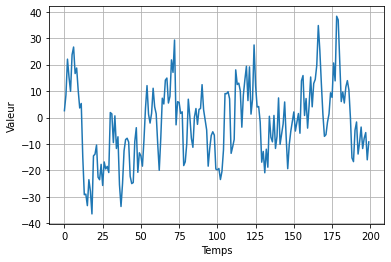

In [ ]:
serie = autocorrelation1(temps, 10, graine=42)
affiche_serie(temps[:200], serie[:200])
plt.show()

In [ ]:
series = autocorrelation(time, 10, seed=42) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

NameError: ignored

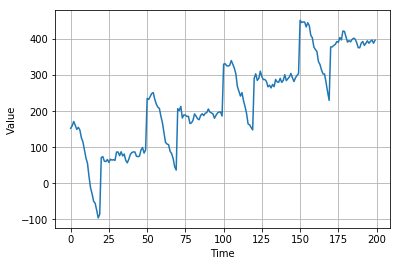

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
plot_series(time[:200], series[:200])
plt.show()

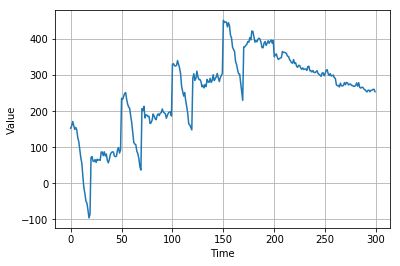

In [ ]:
series = autocorrelation(time, 10, seed=42) + seasonality(time, period=50, amplitude=150) + trend(time, 2)
series2 = autocorrelation(time, 5, seed=42) + seasonality(time, period=50, amplitude=2) + trend(time, -1) + 550
series[200:] = series2[200:]
#series += noise(time, 30)
plot_series(time[:300], series[:300])
plt.show()

In [ ]:
def impulses(time, num_impulses, amplitude=1, seed=None):
    rnd = np.random.RandomState(seed)
    impulse_indices = rnd.randint(len(time), size=10)
    series = np.zeros(len(time))
    for index in impulse_indices:
        series[index] += rnd.rand() * amplitude
    return series    

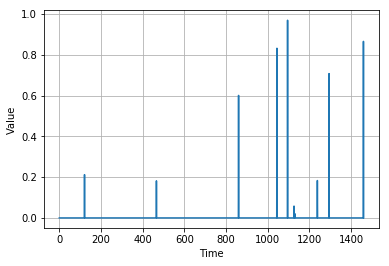

In [ ]:
series = impulses(time, 10, seed=42)
plot_series(time, series)
plt.show()

In [ ]:
def autocorrelation(source, φs):
    ar = source.copy()
    max_lag = len(φs)
    for step, value in enumerate(source):
        for lag, φ in φs.items():
            if step - lag > 0:
              ar[step] += φ * ar[step - lag]
    return ar

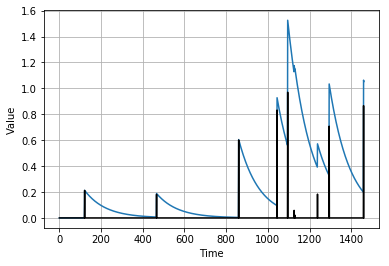

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.99})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

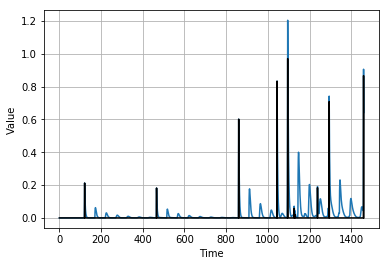

In [ ]:
signal = impulses(time, 10, seed=42)
series = autocorrelation(signal, {1: 0.70, 50: 0.2})
plot_series(time, series)
plt.plot(time, signal, "k-")
plt.show()

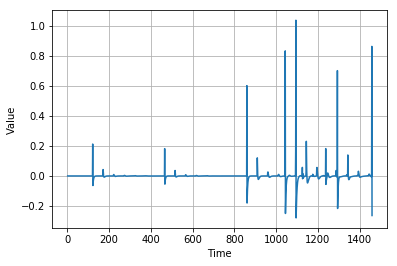

In [ ]:
series_diff1 = series[1:] - series[:-1]
plot_series(time[1:], series_diff1)

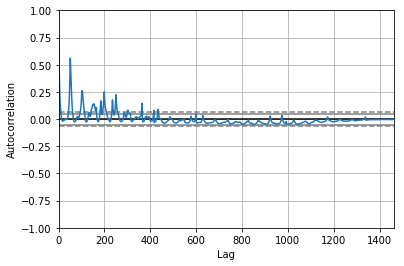

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(series, order=(5, 1, 0))
model_fit = model.fit(disp=0)
print(model_fit.summary())


                             ARIMA Model Results                              
Dep. Variable:                    D.y   No. Observations:                 1460
Model:                 ARIMA(5, 1, 0)   Log Likelihood                2223.428
Method:                       css-mle   S.D. of innovations              0.053
Date:                Tue, 30 Jul 2019   AIC                          -4432.855
Time:                        17:40:55   BIC                          -4395.852
Sample:                             1   HQIC                         -4419.052
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0003      0.001      0.384      0.701      -0.001       0.002
ar.L1.D.y     -0.1235      0.026     -4.714      0.000      -0.175      -0.072
ar.L2.D.y     -0.1254      0.029     -4.333      0.0

In [ ]:
df = pd.read_csv("sunspots.csv", parse_dates=["Date"], index_col="Date")
series = df["Monthly Mean Total Sunspot Number"].asfreq("1M")
series.head()

In [ ]:
series.plot(figsize=(12, 5))

In [ ]:
series["1995-01-01":].plot()

In [ ]:
series.diff(1).plot()
plt.axis([0, 100, -50, 50])

In [ ]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(series)

In [ ]:
autocorrelation_plot(series.diff(1)[1:])

In [ ]:
autocorrelation_plot(series.diff(1)[1:].diff(11 * 12)[11*12+1:])
plt.axis([0, 500, -0.1, 0.1])

In [ ]:
autocorrelation_plot(series.diff(1)[1:])
plt.axis([0, 50, -0.1, 0.1])

In [ ]:
116.7 - 104.3

In [ ]:
[series.autocorr(lag) for lag in range(1, 50)]

In [ ]:
pd.read_csv(filepath_or_buffer, sep=',', delimiter=None, header='infer', names=None, index_col=None, usecols=None, squeeze=False, prefix=None, mangle_dupe_cols=True, dtype=None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, iterator=False, chunksize=None, compression='infer', thousands=None, decimal=b'.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, dialect=None, tupleize_cols=None, error_bad_lines=True, warn_bad_lines=True, delim_whitespace=False, low_memory=True, memory_map=False, float_precision=None)
Read a comma-separated values (csv) file into DataFrame.


In [ ]:
from pandas.plotting import autocorrelation_plot

series_diff = series
for lag in range(50):
  series_diff = series_diff[1:] - series_diff[:-1]

autocorrelation_plot(series_diff)

In [ ]:
import pandas as pd

series_diff1 = pd.Series(series[1:] - series[:-1])
autocorrs = [series_diff1.autocorr(lag) for lag in range(1, 60)]
plt.plot(autocorrs)
plt.show()